In [1]:
#---- Import necessary libraries ----#
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
import pandas as pd
from astropy.constants import G, c, M_sun
#plancks mass
from astropy.constants import m_p as M_p
import astropy.units as u
from scipy.optimize import fsolve

plt.rcParams.update({
    "text.usetex": True,                
    "font.family": "serif",
    "font.serif": ["Computer Modern"],
    "figure.dpi": 200,                   
    "grid.alpha": 0.4,                    
})


EoS MIT Bag Model

$$
p = \frac{1}{3}(\epsilon - 4 B)
$$

In [2]:
hc = 197.327 # MeV fm

B_1 = 145 **4 / (hc**3) # MeV/fm^3
B_SI_1 = (B_1 * u.MeV / u.fm**3).to(u.J / u.m**3).value #J/m³
B_geo_1 = (G.value / c.value**4) * B_SI_1  # m^-2



B_2 = 200 **4 / (hc**3) # MeV/fm^3
B_SI_2 = (B_2 * u.MeV / u.fm**3).to(u.J / u.m**3).value
B_geo_2 = (G.value / c.value**4) * B_SI_2  # m^-2

n0 = 0.16 # fm^-3

Adimensional 

$$

p' = \frac{p}{4B} \qquad \epsilon' = \frac{\epsilon}{4B}  \qquad  M' = 2\sqrt{B} M \qquad R' = 2\sqrt{B} R
$$

In [1]:
def number_density_massive(mu, mass):
    # Per s (quark) n = kF^3/pi^2, mu = kF^2 + m^2
    if mu < mass:
        return 0.0
    kF = np.sqrt(mu**2 - mass**2)
    return (kF / hc)**3 / np.pi**2 # MeV/fm^3

def number_density_electron(mu):
    # Electrons: n = kF^3/(3*pi^2), mu = kF
    if mu < 0: return 0
    return (mu / hc)**3 / (3 * np.pi**2) # MeV/fm^3


def pressure_f_massless(N_c, mu_q, m_q):
    factor  = N_c * mu_q**4 / (24 * np.pi**2 * hc**3)
    return factor  # MeV/fm^3

def energy_f_massless(N_c, mu_q, m_q):
    factor  = N_c * mu_q**4 / (8 * np.pi**2 * hc**3)
    return factor # MeV/fm^3

In [4]:
#for massless quarks
m_u = 0.0 # MeV
m_d = 0.0 # MeV
m_s = 0.0 # MeV
m_e = 0.0  # MeV


N_c_quarks = 3
N_c_lep = 1

# Compute numerical values for the EoS

In [5]:
# --- SISTEMA D'EQUACIONS A RESOLTRE ---

def equationsNB(vars, nB_target):
    mu_u, mu_e= vars
    
    # Beta equilibri
    mu_d = mu_u + mu_e
    mu_s = mu_d 
    
    # Densitats
    nu = number_density_massive(mu_u, m_u)
    nd = number_density_massive(mu_d, m_d)
    ns = number_density_massive(mu_s, m_s)
    ne = number_density_electron(mu_e)

    # 2/3 nu - 1/3 nd - 1/3 ns - ne = 0
    eq_charge = (2/3)*nu - (1/3)*nd - (1/3)*ns - ne

    # 1/3 (nu + nd + ns) = nB
    eq_baryon = (1/3)*(nu + nd + ns) - nB_target

    return [eq_charge, eq_baryon]
    

Number of points in EOS with positive pressure: 9967
Failed points (negative pressure): 33
Number of points in EOS with positive pressure: 9910
Failed points (negative pressure): 90


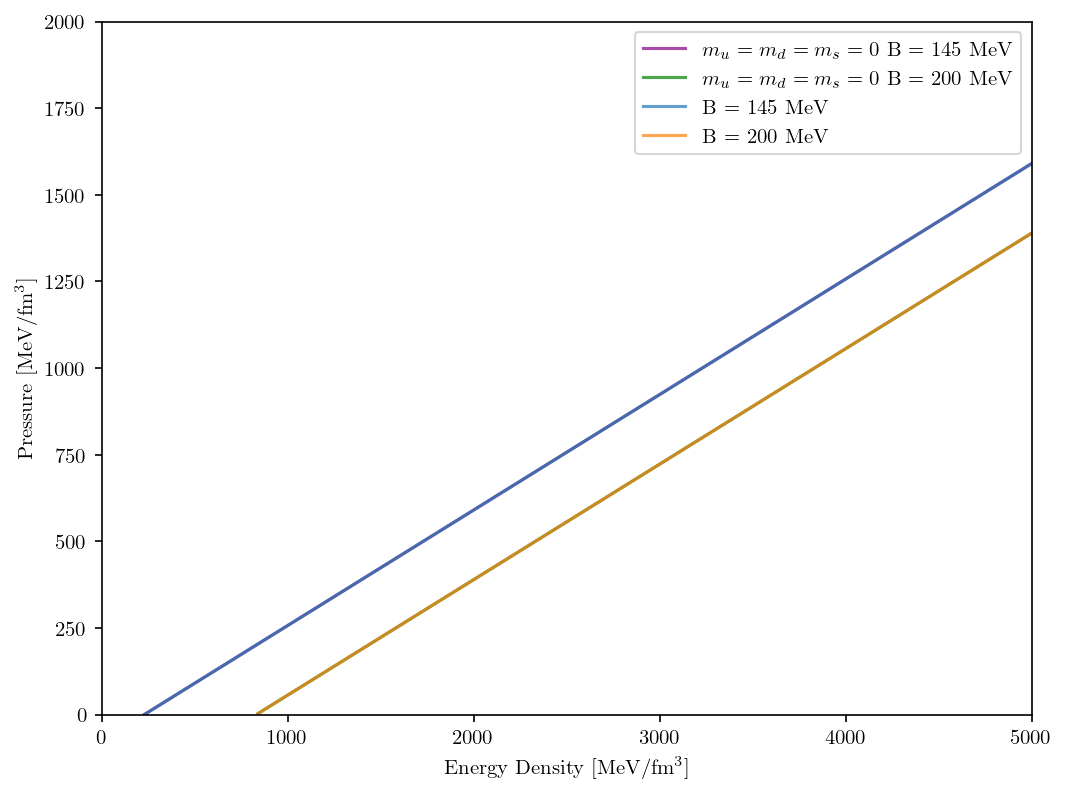

In [6]:

list_nb_1 = np.linspace(0.1, 500, 10000) * n0
list_failed_nb_1 = []


list_e_1 = []
list_p_1 = []
guess = [300, 100]  # Initial guess for mu_u and mu_e in MeV

for nB in list_nb_1:
    sol = fsolve(equationsNB, guess, args=(nB))
    mu_u, mu_e = sol    
    mu_d = mu_u + mu_e
    mu_s = mu_d

    nu = number_density_massive(mu_u, m_u)
    nd = number_density_massive(mu_d, m_d)
    ns = number_density_massive(mu_s, m_s)
    ne = number_density_electron(mu_e)

    check_nb = (1/3)*(nu + nd + ns) - nB
    check_charge = (2/3)*nu - (1/3)*nd - (1/3)*ns - ne

    if abs(check_nb) > 1e-6:
        print(f"Warning: nB check failed: {check_nb:.3e} fm^-3")

    if abs(check_charge) > 1e-6:
        print(f"Warning: charge neutrality check failed: {check_charge:.3e} fm^-3")


    pressure_total = (pressure_f_massless(6, mu_u, m_u) + pressure_f_massless(6, mu_d, m_d) +
                    pressure_f_massless(6, mu_s, m_s) + pressure_f_massless(2, mu_e, m_e)) - B_1

    if pressure_total < 0:
        #print('Negative pressure reached, stopping at nB=', nB)
        list_failed_nb_1.append(nB)
        continue


    energy_total =  (energy_f_massless(6, mu_u, m_u) + energy_f_massless(6, mu_d, m_d) +
                    energy_f_massless(6, mu_s, m_s) + energy_f_massless(2, mu_e, m_e)) + B_1


    list_e_1.append(energy_total) # MeV/fm^3
    list_p_1.append(pressure_total) # MeV/fm^3



plt.figure(figsize=(8,6), dpi=150)

plt.plot(list_e_1, list_p_1, 
        label='$m_u = m_d = m_s=  0$ B = 145 MeV', color='purple', alpha=0.7)
plt.xlabel('Energy Density [MeV/fm$^3$]')
plt.ylabel('Pressure [MeV/fm$^3$]')
plt.grid()
plt.legend()







list_nb_1 = list_nb_1[len(list_failed_nb_1):]
print("Number of points in EOS with positive pressure:", len(list_nb_1))
print("Failed points (negative pressure):", len(list_failed_nb_1))



#-------------- Second constant B EOS --------------#

list_nb_2 = np.linspace(0.1, 500, 10000) * n0
list_failed_nb_2 = []


list_e_2 = []
list_p_2 = []
guess = [300, 100]  # Initial guess for mu_u and mu_e in MeV

for nB in list_nb_2:
    sol = fsolve(equationsNB, guess, args=(nB))
    mu_u, mu_e = sol    
    mu_d = mu_u + mu_e
    mu_s = mu_d

    nu = number_density_massive(mu_u, m_u)
    nd = number_density_massive(mu_d, m_d)
    ns = number_density_massive(mu_s, m_s)
    ne = number_density_electron(mu_e)

    check_nb = (1/3)*(nu + nd + ns) - nB
    check_charge = (2/3)*nu - (1/3)*nd - (1/3)*ns - ne

    if abs(check_nb) > 1e-6:
        print(f"Warning: nB check failed: {check_nb:.3e} fm^-3")

    if abs(check_charge) > 1e-6:
        print(f"Warning: charge neutrality check failed: {check_charge:.3e} fm^-3")


    pressure_total = (pressure_f_massless(6, mu_u, m_u) + pressure_f_massless(6, mu_d, m_d) +
                    pressure_f_massless(6, mu_s, m_s) + pressure_f_massless(2, mu_e, m_e)) - B_2

    if pressure_total < 0:
        #print('Negative pressure reached, stopping at nB=', nB)
        list_failed_nb_2.append(nB)
        continue


    energy_total =  (energy_f_massless(6, mu_u, m_u) + energy_f_massless(6, mu_d, m_d) +
                    energy_f_massless(6, mu_s, m_s) + energy_f_massless(2, mu_e, m_e)) + B_2


    list_e_2.append(energy_total)
    list_p_2.append(pressure_total)




plt.plot(list_e_2, list_p_2, 
        label='$m_u = m_d = m_s=  0$ B = 200 MeV', color='green', alpha=0.7)
plt.xlabel('Energy Density [MeV/fm$^3$]')
plt.ylabel('Pressure [MeV/fm$^3$]')
plt.grid()







plt.xlim(0, 5000)
plt.ylim(0, 2000)

list_nb_2 = list_nb_2[len(list_failed_nb_2):]
print("Number of points in EOS with positive pressure:", len(list_nb_2))
print("Failed points (negative pressure):", len(list_failed_nb_2))

list_e_1 = np.array(list_e_1 )
list_e_2 = np.array(list_e_2 )

p_1 = 1/3*(list_e_1 - 4*B_1)
p_2 = 1/3*(list_e_2 - 4*B_2)

plt.plot(list_e_1, p_1, label='B = 145 MeV', alpha=0.7)
plt.plot(list_e_2, p_2, label='B = 200 MeV', alpha=0.7)

plt.legend()




plt.show()

The EoS is working

In [7]:
#convert pressure and energy density to geometric units
list_p_geo_1 = (G.value / c.value**4) * (np.array(list_p_1) * u.MeV / u.fm**3).to(u.J / u.m**3).value  # m^-2
list_e_geo_1 = (G.value / c.value**4) * (np.array(list_e_1) * u.MeV / u.fm**3).to(u.J / u.m**3).value  # m^-2
list_p_geo_2 = (G.value / c.value**4) * (np.array(list_p_2) * u.MeV / u.fm**3).to(u.J / u.m**3).value  # m^-2
list_e_geo_2 = (G.value / c.value**4) * (np.array(list_e_2) * u.MeV / u.fm**3).to(u.J / u.m**3).value  # m^-2


list_p_geo_1_adim = list_p_geo_1 / (4*B_geo_1)
list_p_geo_2_adim = list_p_geo_2 / (4*B_geo_2)
list_e_geo_1_adim = list_e_geo_1 / (4*B_geo_1)
list_e_geo_2_adim = list_e_geo_2 / (4*B_geo_2)

TOV: G = c = 1 

$$
\frac{dp}{dr} = - \frac{M \epsilon}{r^2} \left(1+\frac{p}{\epsilon}\right) \left(1+ \frac{4\pi r^3 p}{M}\right)\left(1-\frac{2M}{r}\right)^{-1}
$$

$$
\frac{dM}{dr} = 4 \pi r^2 \epsilon
$$

Already wihout dimensions

In [8]:

def solve_TOV(central_energy, x0):
    def ode_TOV_1(r, x):
            p, M = x
            if p < 0:
                return [0, 0]
            
            e = np.interp(p, list_p_geo_1_adim, list_e_geo_1_adim)

            term1 = e * M / r**2
            term2 = 1 + p / e
            if M == 0:
                term3 = 1.0
            else:
                term3 = 1.0 + 4 * np.pi * r**3 * p / M
            term4 = 1 - 2 * M / r

            if term4 <= 0:
                return [0, 0]

            dpdr = - term1 * term2 * term3 / term4
            dMdr =  4 * np.pi * r**2 * e

            return [dpdr, dMdr]

    
    # ----------------------------------------------------
    # Solve ODE
    # ----------------------------------------------------

    # This solver automatically adjusts step size to control error
    sol = solve_ivp(
        ode_TOV_1,
        (r0, 100),     # integrate up to r=100 (large enough)
        x0,
        events=surface_event,
        max_step=0.1,
        rtol=1e-8, atol=1e-10 #tolerance error
    )

    if len(sol.t_events[0]) == 0:
        print(f"No surface event for central energy = {central_energy}")
        return np.nan, np.nan
    
    M_surface = sol.y_events[0][0][1]
    P_surface = sol.y_events[0][0][0]
    R_surface = sol.t_events[0][0]

    if P_surface > 1e-5 :
        print("Final pressure is far from 0:", P_surface * (4 * B_geo_1), 'MeV/fm^3')

    
    return R_surface, M_surface


# ----------------------------------------------------
# Event: stop integration when pressure goes to zero
# ----------------------------------------------------
def surface_event(r, x):
    return x[0]       # detects when between steps the pressure changes sign: pressure = 0, 
                      # the value given is not the pressure at that step, but an interpolation of where the pressure would be zero
surface_event.terminal = True # stop the integration
surface_event.direction = -1 # only detect zero-crossing from positive to negative


list_R_1 = []
list_M_1 = []


#list_p_adim_1 = np.array(list_p_1)/(4 * B_1)
#list_e_adim_1 = np.array(list_e_1)/(4 * B_1)



for i in range(0, len(list_nb_1), 5):

    e, p = list_e_geo_1_adim[i], list_p_geo_1_adim[i]

    r0 = 1e-5

    central_mass = (4/3) * np.pi * r0**3 * e

    x0 = [p, central_mass]


    R_surface, M_surface = solve_TOV(e, x0)


    list_R_1.append(R_surface)
    list_M_1.append(M_surface)



Now for the second constant

In [9]:

def solve_TOV(central_energy, x0):
    def ode_TOV_2(r, x):
            p, M = x
            if p < 0:
                return [0, 0]

            e = np.interp(p, list_p_geo_2_adim, list_e_geo_2_adim)

            term1 = e * M / r**2
            term2 = 1 + p / e
            if M == 0:
                term3 = 1.0
            else:
                term3 = 1.0 + 4 * np.pi * r**3 * p / M
            term4 = 1 - 2 * M / r

            if term4 <= 0:
                return [0, 0]

            dpdr = - term1 * term2 * term3 / term4
            dMdr =  4 * np.pi * r**2 * e

            return [dpdr, dMdr]

    
    # ----------------------------------------------------
    # Solve ODE
    # ----------------------------------------------------

    # This solver automatically adjusts step size to control error
    sol = solve_ivp(
        ode_TOV_2,
        (r0, 100),     # integrate up to r=100 (large enough)
        x0,
        events=surface_event,
        max_step=0.1,
        rtol=1e-8, atol=1e-10 #tolerance error
    )

    if len(sol.t_events[0]) == 0:
        print(f"No surface event for central energy = {central_energy}")
        return np.nan, np.nan
    
    M_surface = sol.y_events[0][0][1]
    P_surface = sol.y_events[0][0][0]
    R_surface = sol.t_events[0][0]


    if P_surface > 1e-5 :
        print("Final pressure is far from 0:", P_surface * (4 * B_geo_2), 'MeV/fm^3')
    
    return R_surface, M_surface


# ----------------------------------------------------
# Event: stop integration when pressure goes to zero
# ----------------------------------------------------
def surface_event(r, x):
    return x[0]       # detects when between steps the pressure changes sign: pressure = 0, 
                      # the value given is not the pressure at that step, but an interpolation of where the pressure would be zero
surface_event.terminal = True # stop the integration
surface_event.direction = -1 # only detect zero-crossing from positive to negative


list_R_2 = []
list_M_2 = []


#list_p_adim_2 = np.array(list_p_2)/(4 * B_2)
#list_e_adim_2 = np.array(list_e_2)/(4 * B_2)



for i in range(0, len(list_nb_2),5):
    e, p = list_e_geo_2_adim[i], list_p_geo_2_adim[i]


    r0 = 1e-5                   

    central_mass = (4/3) * np.pi * r0**3 * e

    x0 = [p, central_mass]


    R_surface, M_surface = solve_TOV(e, x0)


    list_R_2.append(R_surface)
    list_M_2.append(M_surface)


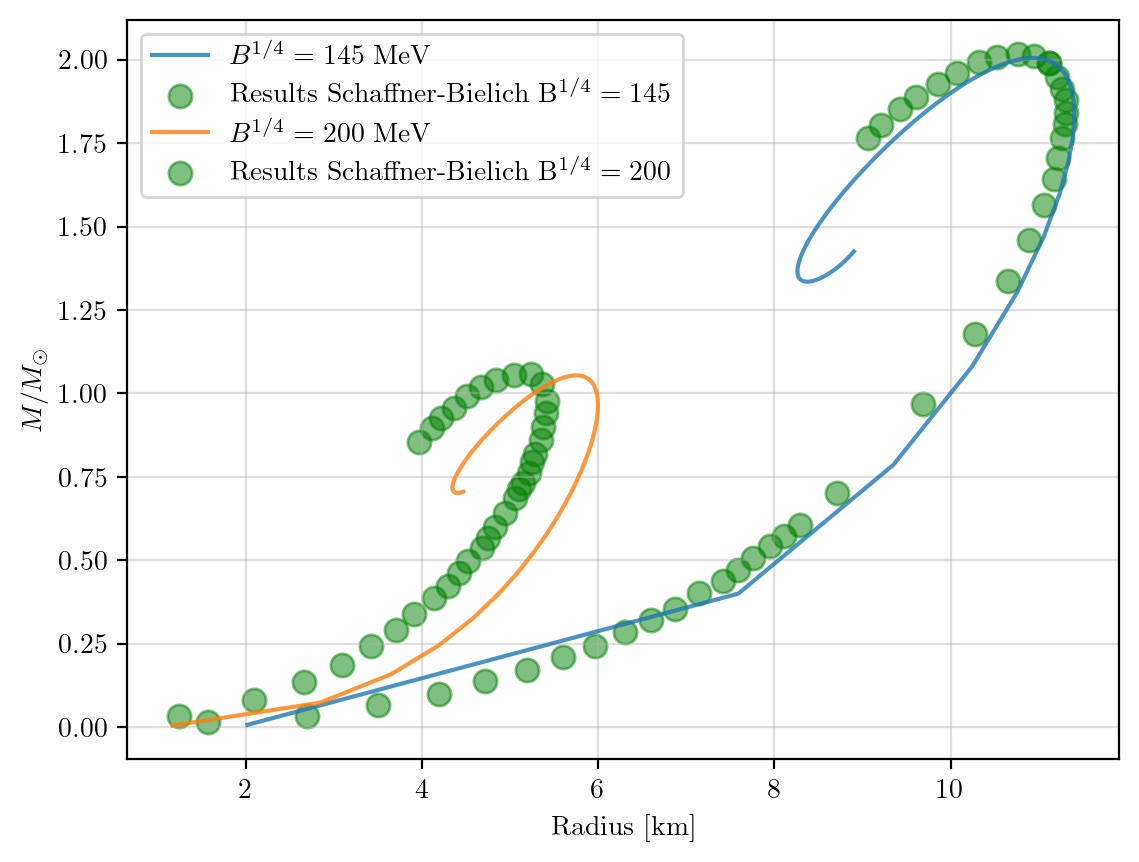

In [10]:

# --- Convert dimensionless R', M' ---
R_km_1 = list_R_1 / (2 * np.sqrt(B_geo_1)) * 1e-3
M_meters_1 = list_M_1 / (2 * np.sqrt(B_geo_1))
M_solar_1 = (M_meters_1 * c.value**2 / G.value) / M_sun.value
plt.plot(R_km_1, M_solar_1, label=r'$B^{1/4}=145\ \mathrm{MeV}$', alpha=0.8)


data = pd.read_csv('Data/BagModel145.csv')
data= data[:-2]
data = data.drop(32)
data = data.drop(33)
plt.scatter(data['x'], data[' y'], label='Results  Schaffner-Bielich B$^{1/4}=145$', s=70, alpha=0.5,color='green')




# --- Convert B to geometrized units ---

# --- Convert dimensionless R', M' ---
R_km_2 = list_R_2 / (2 * np.sqrt(B_geo_2)) * 1e-3
M_meters_2 = list_M_2/ (2 * np.sqrt(B_geo_2))
M_solar_2 = (M_meters_2 * c.value**2 / G.value) / M_sun.value
plt.plot(R_km_2, M_solar_2, label=r'$B^{1/4}=200\ \mathrm{MeV}$', alpha=0.8)


data = pd.read_csv('Data/BagModel200.csv')

plt.scatter(data['x'], data[' y'], label='Results  Schaffner-Bielich B$^{1/4}=200$', s=70, alpha=0.5,color='green')

# --- Plot ---

plt.xlabel("Radius [km]")
plt.ylabel(r"$M/M_\odot$")
plt.grid()
plt.legend()
plt.show()
